In [1]:
import os
import cv2
import numpy as np
import warnings
from natsort import natsorted
import matplotlib.pyplot as plt
import subprocess
import random
warnings.filterwarnings("ignore")

os.chdir('..')

In [2]:
class HornSchunckPositionDetector:
    '''
    Horn-Schunck optical flow detector that marks bright red points at motion hotspots.
    '''

    def __init__(self, video_path, output_dir, alpha=1.0, num_iter=100):
        self.video_path = video_path
        self.output_dir = output_dir
        self.alpha = alpha
        self.num_iter = num_iter

        os.makedirs(self.output_dir, exist_ok=True)

    def _horn_schunck(self, im1, im2):
        im1 = im1.astype(float) / 255.
        im2 = im2.astype(float) / 255.

        Ix = cv2.Sobel(im1, cv2.CV_64F, 1, 0, ksize=5)
        Iy = cv2.Sobel(im1, cv2.CV_64F, 0, 1, ksize=5)
        It = im2 - im1

        u = np.zeros(im1.shape)
        v = np.zeros(im1.shape)

        kernel = np.array([[1/12, 1/6, 1/12],
                           [1/6,   0,  1/6],
                           [1/12, 1/6, 1/12]])

        for _ in range(self.num_iter):
            u_avg = cv2.filter2D(u, -1, kernel)
            v_avg = cv2.filter2D(v, -1, kernel)

            deriv = (Ix * u_avg + Iy * v_avg + It) / (self.alpha**2 + Ix**2 + Iy**2)
            u = u_avg - Ix * deriv
            v = v_avg - Iy * deriv

        return u, v

    def detect(self):
        cap = cv2.VideoCapture(self.video_path)
        ret, old_frame = cap.read()
        if not ret:
            print(f"[Error] Could not read video: {self.video_path}")
            cap.release()
            return

        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        frame_id = 0

        while True:
            frame_id += 1
            ret, frame = cap.read()
            if not ret:
                break

            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            u, v = self._horn_schunck(old_gray, frame_gray)

            mag, _ = cv2.cartToPolar(u, v)
            threshold = 0.2  # Lower threshold to capture subtle motion

            # Copy original frame to mark red points
            output_frame = frame.copy()

            # Draw bright red circles at high-motion points
            y_indices, x_indices = np.where(mag > threshold)
            for y, x in zip(y_indices, x_indices):
                cv2.circle(output_frame, (x, y), 2, (0, 0, 255), -1)  # Bright red dot

            cv2.imwrite(os.path.join(self.output_dir, f'frame_{frame_id}.jpg'), output_frame)

            old_gray = frame_gray.copy()

        cap.release()
        cv2.destroyAllWindows()
        print(f"[Done] Processed video saved to: {self.output_dir}")
        return self.output_dir

In [5]:
class VideoCreator:
    '''
    Class to create a video from a series of image frames.

    Args:
        frame_dir (str): Directory containing the image frames.
        output_path (str): Path to save the output video. Default is "output/video_output.mp4".
        fps (int): Frames per second for the output video. Default is 30.

    Methods:
        _load_frames(): Loads image frames from the specified directory.
        _get_frame_size(): Gets the size of the first frame to set video dimensions.
        create_video(): Creates a video from the loaded frames and saves it to the specified output path.

    Returns:
        A video file created from the image frames is saved to the specified output path.
    '''

    def __init__(self, frame_dir, output_path="output/output_video.mp4", fps=30):
        self.frame_dir = frame_dir
        self.output_path = output_path
        self.fps = fps
        self.frames = self._load_frames()

        if not self.frames:
            raise ValueError(f"No frames found in directory: {frame_dir}")

        self.frame_size = self._get_frame_size(self.frames[0])
        self.fourcc = self._choose_fourcc()


    def _load_frames(self):
        valid_exts = ('.jpg', '.jpeg', '.png')
        return natsorted([f for f in os.listdir(self.frame_dir) if f.lower().endswith(valid_exts)])


    def _get_frame_size(self, sample_file):
        path = os.path.join(self.frame_dir, sample_file)
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Can't read sample frame: {sample_file}")
        return (img.shape[1], img.shape[0])


    def _choose_fourcc(self):
        ext = os.path.splitext(self.output_path)[-1].lower()
        if ext == ".avi":
            return cv2.VideoWriter_fourcc(*"XVID")
        else:  # .mp4 or others
            return cv2.VideoWriter_fourcc(*"mp4v")


    def create_video(self):
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        writer = cv2.VideoWriter(self.output_path, self.fourcc, self.fps, self.frame_size)

        for f in self.frames:
            img = cv2.imread(os.path.join(self.frame_dir, f))
            if img is None:
                print(f"Skipping unreadable frame: {f}")
                continue
            if (img.shape[1], img.shape[0]) != self.frame_size:
                img = cv2.resize(img, self.frame_size)
            writer.write(img)

        writer.release()
        return self.output_path




def convert_to_modern_mp4(input_path, output_path):
    cmd = [
        "ffmpeg",
        "-y",
        "-i", input_path,
        "-c:v", "libx264",
        "-preset", "fast",
        "-crf", "23",
        "-c:a", "aac",
        "-b:a", "128k",
        output_path
    ]
    subprocess.run(cmd, check=True)
    print(f"Video successfully saved to: {output_path}")
    os.remove(input_path)
    return input_path


## Example 1

In [6]:
file_name = 'demo1'

detector = HornSchunckPositionDetector(
    video_path=f"data/{file_name}.mp4",
    output_dir=f"frames/horn_schunck/{file_name}",
    alpha=1.0,
    num_iter=100
)
frame_dir = detector.detect()


vc = VideoCreator(frame_dir, output_path=f"output/{file_name}_output_horn_schunck.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{file_name}_output_horn_schunck.mp4")

print(f"Output video saved at: {output_mp4_file}")

[Done] Processed video saved to: frames/horn_schunck/demo1


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo1_output_horn_schunck.mp4
Output video saved at: output/demo1_output_horn_schunck.avi


frame=  164 fps=0.0 q=-1.0 Lsize=     993kB time=00:00:05.36 bitrate=1516.4kbits/s speed=7.28x    
video:991kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.268988%
[libx264 @ 0x58429aca5cc0] frame I:3     Avg QP:21.16  size: 47786
[libx264 @ 0x58429aca5cc0] frame P:57    Avg QP:19.91  size:  8291
[libx264 @ 0x58429aca5cc0] frame B:104   Avg QP:22.91  size:  3826
[libx264 @ 0x58429aca5cc0] consecutive B-frames: 12.8%  7.3%  1.8% 78.0%
[libx264 @ 0x58429aca5cc0] mb I  I16..4: 29.9% 49.9% 20.2%
[libx264 @ 0x58429aca5cc0] mb P  I16..4:  2.4%  9.1%  1.1%  P16..4: 16.3%  4.6%  2.2%  0.0%  0.0%    skip:64.4%
[libx264 @ 0x58429aca5cc0] mb B  I16..4:  0.7%  2.6%  0.5%  B16..8: 11.5%  2.3%  0.3%  direct: 2.0%  skip:80.1%  L0:54.5% L1:39.9% BI: 5.5%
[libx264 @ 0x58429aca5cc0] 8x8 transform intra:66.4% inter:67.1%
[libx264 @ 0x58429aca5cc0] coded y,uvDC,uvAC intra: 41.0% 52.4% 24.8% inter: 3.8% 5.2% 1.8%
[libx264 @ 0x58429aca5cc0] i16 v,h,dc,p: 41% 40% 13%  6%
[li

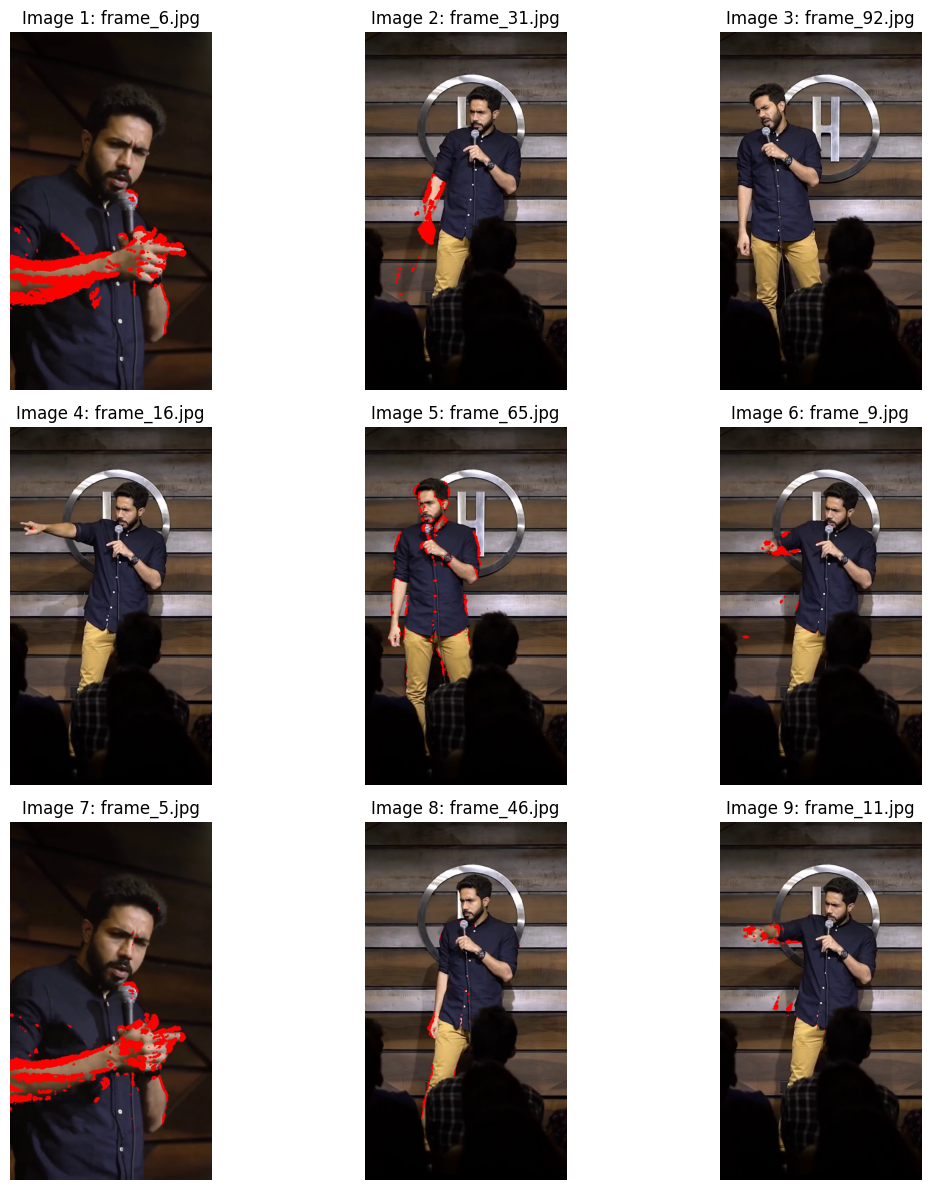

In [7]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) < 100]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Example 2

In [8]:
file_name = 'demo2'

detector = HornSchunckPositionDetector(
    video_path=f"data/{file_name}.mp4",
    output_dir=f"frames/horn_schunck/{file_name}",
    alpha=1.0,
    num_iter=100
)
frame_dir = detector.detect()


vc = VideoCreator(frame_dir, output_path=f"output/{file_name}_output_horn_schunck.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{file_name}_output_horn_schunck.mp4")

print(f"Output video saved at: {output_mp4_file}")

[Done] Processed video saved to: frames/horn_schunck/demo2


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo2_output_horn_schunck.mp4
Output video saved at: output/demo2_output_horn_schunck.avi


frame=  538 fps=0.0 q=-1.0 Lsize=    1935kB time=00:00:17.83 bitrate= 889.0kbits/s speed=21.1x    
video:1928kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.365715%
[libx264 @ 0x618649b9b3c0] frame I:3     Avg QP:19.91  size: 19118
[libx264 @ 0x618649b9b3c0] frame P:153   Avg QP:21.99  size:  7004
[libx264 @ 0x618649b9b3c0] frame B:382   Avg QP:25.23  size:  2211
[libx264 @ 0x618649b9b3c0] consecutive B-frames:  3.5%  3.7%  5.0% 87.7%
[libx264 @ 0x618649b9b3c0] mb I  I16..4: 22.7% 63.6% 13.8%
[libx264 @ 0x618649b9b3c0] mb P  I16..4:  3.3%  9.2%  2.0%  P16..4: 42.6% 14.1%  7.1%  0.0%  0.0%    skip:21.8%
[libx264 @ 0x618649b9b3c0] mb B  I16..4:  1.2%  2.9%  0.4%  B16..8: 29.9%  7.0%  1.1%  direct: 6.8%  skip:50.8%  L0:50.1% L1:40.3% BI: 9.6%
[libx264 @ 0x618649b9b3c0] 8x8 transform intra:63.8% inter:54.0%
[libx264 @ 0x618649b9b3c0] coded y,uvDC,uvAC intra: 48.4% 72.6% 26.3% inter: 10.4% 18.6% 3.2%
[libx264 @ 0x618649b9b3c0] i16 v,h,dc,p: 19% 54% 20%  7%


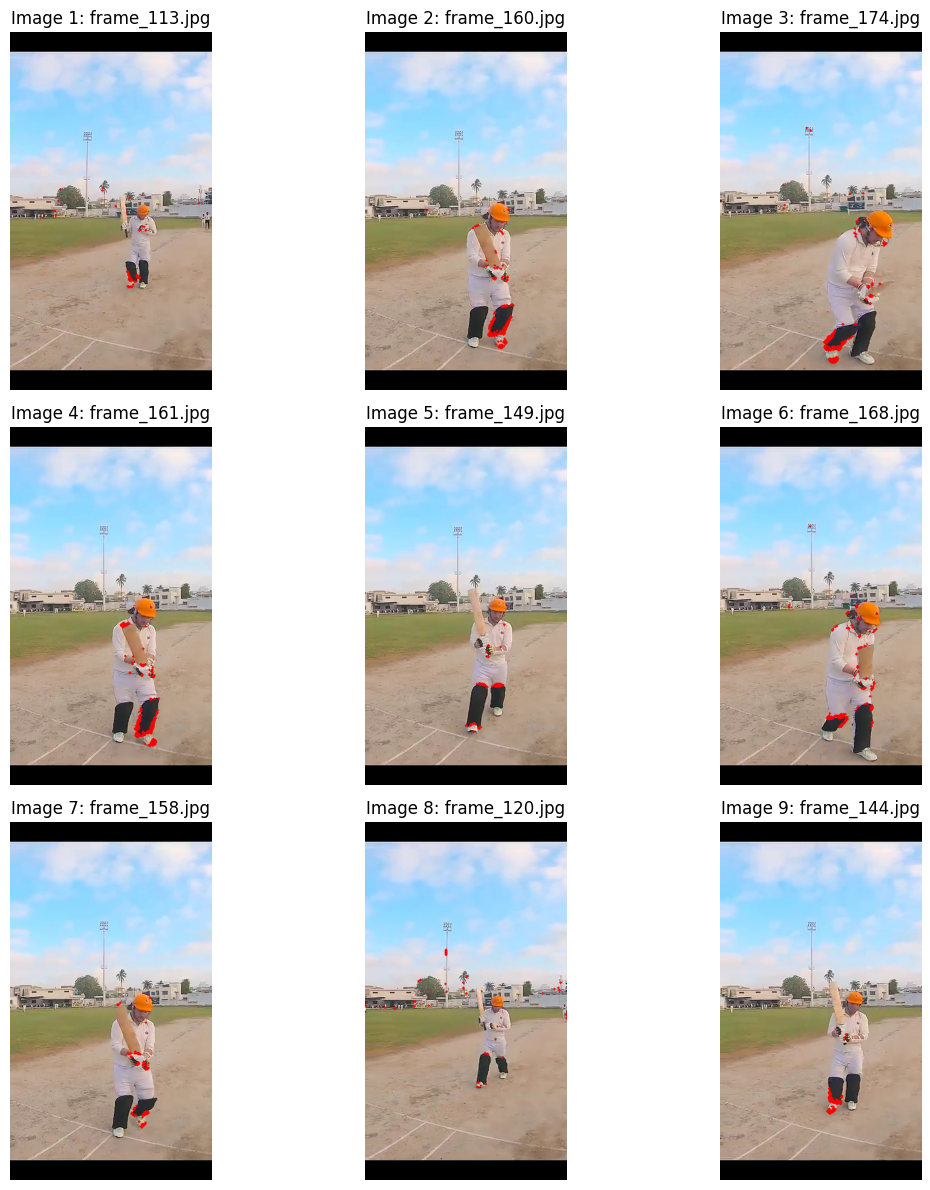

In [10]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) > 100 and int(f.split('_')[1].split('.')[0]) < 200]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()